In [20]:
%load_ext autoreload
%autoreload 2

import os
import sys
# This is done so that the notebook can see files
# placed in a different folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from environment.Environment import Env2048

from tf_agents.environments import utils
from tf_agents.environments import wrappers
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

import tensorflow as tf
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [17]:
train_env = tf_py_environment.TFPyEnvironment(Env2048())
eval_env = tf_py_environment.TFPyEnvironment(Env2048())

In [25]:
train_env.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32))

In [27]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    time_step_spec = train_env.time_step_spec(),
    action_spec = train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

ValueError: Expected q_network to emit a floating point tensor with inner dims (4,); but saw network output spec: TensorSpec(shape=(4, 4), dtype=tf.float32, name=None)
  In call to configurable 'DqnAgent' (<class 'tf_agents.agents.dqn.dqn_agent.DqnAgent'>)

## -----------------

In [31]:
env = tf_py_environment.TFPyEnvironment(Env2048())
# env = Env2048()

rewards = []
max_rewards = []
steps = []
total_rewards = []
env.reset()

for i in range(3000):
    if not i % 100:
        print(i)
    time_step = env.step(np.array(np.random.randint(4), dtype=np.int32))
    while not time_step.is_last():
        time_step = env.step(np.array(np.random.randint(4), dtype=np.int32))
    if time_step.is_last():
        pyenv = env.pyenv.envs[0]
#         pyenv = env
        rewards += pyenv.get_state().reward_history
        steps += [pyenv.get_state().step_count]
        total_rewards += [pyenv.get_state().total_reward]
        max_rewards += [pyenv.get_state().max_reward]
        env.reset()


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


(array([ 12.,  96., 132.,  11., 495., 349., 232.,  41.,  35.,   2., 364.,
        501., 323.,  84.,  82.,  18.,   4.,   6.,   5.,   1.,   0.,   0.,
          0.,  56.,  70.,  43.,  17.,  13.,   2.,   2.,   3.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 20.  ,  29.92,  39.84,  49.76,  59.68,  69.6 ,  79.52,  89.44,
         99.36, 109.28, 119.2 , 129.12, 139.04, 148.96, 158.88, 168.8 ,
        178.72, 188.64, 198.56, 208.48, 218.4 , 228.32, 238.24, 248.16,
        258.08, 268.  , 277.92, 287.84, 297.76, 307.68, 317.6 , 327.52,
        337.44, 347.36, 357.28, 367.2 , 377.12, 387.04, 396.96, 406.88,
        416.8 , 426.72, 436.64, 446.56, 456.48, 466.4 , 476.32, 486.24,
        496.16, 506.08, 516.  ]),
 <BarContainer object of 50 artists>)

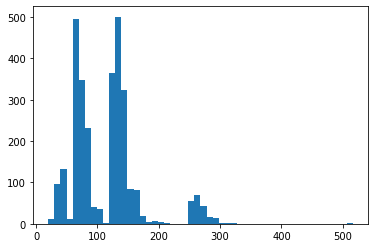

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.hist(rewards, bins=50)
# plt.hist(steps, bins=50)
# plt.hist(total_rewards, bins=50)
plt.hist(max_rewards, bins=50)